# Modeling Spatial Conflict through POI-Based Mobility

In this project, we simulate spatial conflict between two groups (Group A and Group B) within an urban environment. Unlike traditional lattice-based models where agents interact at fixed positions, we introduce **mobility** via predefined **Points of Interest (POIs)** such as schools, transit hubs, or markets.

Agents travel from their home location to a POI, and if agents from opposing groups are present at the same POI, conflict may occur. This model allows us to study how **urban mobility patterns influence the emergence, persistence, or resolution of group-based spatial conflict**.


# Step 1: Model Description – Mobility-Based Spatial Conflict via Points of Interest (POIs)

## Objective of the Model

The goal of this agent-based model is to simulate **spatial conflict between two rival groups** (Group A and Group B) within a simplified urban environment. Unlike classical models of spatial conflict—such as the one proposed by Clifford and Sudbury (1973)—this model introduces **agent mobility** and interaction constraints based on **Points of Interest (POIs)**.

## Why This Extension?

Clifford and Sudbury’s model assumes that conflict arises via *static, local interactions* on a fixed lattice. Every agent sits in a cell and interacts only with its neighbors. While elegant, this abstraction lacks **mobility, heterogeneity of space**, and the influence of **urban social mixing** patterns, which are critical in real-world spatial conflict (e.g., between ethnic, political, or social groups).

In contrast, this model reflects a more **urbanized and behaviorally realistic setting** where:
- Agents live separately but **interact only when visiting shared urban locations**, such as markets, schools, or transit stations.
- Conflicts emerge *not because of geographical proximity alone*, but due to repeated **co-presence in specific high-interaction zones**.

## Key Features of the Model

- Agents are assigned to one of two groups and are mobile.
- At each simulation step, an agent travels to a **randomly selected POI**.
- When multiple agents from different groups meet at a POI, a **conflict may occur** with some probability.
- The number and spatial arrangement of POIs can be modified to assess how **environmental design affects group dynamics** and conflict frequency.

## Research Motivation

This model is designed to answer the research question:

> **"How does individual mobility and spatial clustering around urban points of interest (POIs) affect the persistence and resolution of spatial conflicts between opposing groups?"**

By exploring how varying the **number, placement, and density of POIs** influences the emergence of clustering, dominance, or coexistence, we can gain insight into the **role of urban infrastructure in shaping group interactions and tensions**.

The ultimate aim is to observe whether **more POIs lead to increased mixing and reduced conflict**, or if certain configurations inadvertently **intensify group segregation** and friction.

---

This setup establishes the intellectual motivation, technical rationale, and expected outcomes of the model—providing a clear link to both the classic model and modern extensions.


## Step 2: Defining the Agent and Model Structure

In this section, we define two key components of our agent-based model:

1. **`POIAgent` class**: Represents individuals from either Group A or Group B. Each agent:
   - Belongs to a fixed group (representing conflicting identities),
   - Selects a point of interest (POI) to visit at each time step,
   - May engage in conflict if another agent from an opposing group is present at the same POI.

   The agent's core behavior is to **move to a POI** and potentially trigger a **conflict interaction**.

2. **`ConflictModel` class**: Sets up the simulation environment. This includes:
   - A 2D `MultiGrid` (with toroidal boundaries) representing the urban space,
   - A scheduler (`RandomActivation`) to determine the sequence of agent actions,
   - A list of `POI` locations—randomly selected cells where interactions can occur,
   - Initialization of agents with equal numbers from both groups.

### Why This Structure?

The classic Clifford & Sudbury (1973) model assumes fixed agents on a lattice, where interactions occur with immediate neighbors. Our extension breaks this constraint by introducing **explicit mobility**. Agents in this model do not interact on the entire grid but only at predefined high-interaction sites (POIs). This reflects real-world urban settings where group encounters and conflicts are more likely in **shared public spaces** than in isolated cells.

### Additional Design Notes:
- The model currently assumes agents have no memory or strategy. All movement is random, and conflicts are probabilistic.
- POIs are static but can be varied in density to test our core hypothesis.
- This design allows for easy extension, such as adding memory, aggression level, or social ties.

This setup builds the foundational logic for simulating **mobility-based spatial conflict** under urban constraints.



In [50]:
from mesa import Agent, Model
from mesa.space import MultiGrid
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector
import random


# --------- Metrics: OUTSIDE the classes ---------
def count_group_A(model):
    return sum(1 for agent in model.schedule.agents if agent.group == "A")

def count_group_B(model):
    return sum(1 for agent in model.schedule.agents if agent.group == "B")

# --------- Agent Class ---------
class POIAgent(Agent):
    def __init__(self, unique_id, model, group):
        super().__init__(unique_id, model)
        self.group = group
        self.current_location = None

    def step(self):
        self.current_location = random.choice(self.model.poi_locations)
        print(f"Agent {self.unique_id} ({self.group}) moved to {self.current_location}")
        self.model.grid.move_agent(self, self.current_location)
        
        # Conflict check
        others_here = self.model.grid.get_cell_list_contents([self.current_location])
        for other in others_here:
            if other != self and isinstance(other, POIAgent):
                if other.group != self.group:
                    if random.random() < self.model.conflict_prob:
                        print(f"⚔️ Conflict between Agent {self.unique_id} ({self.group}) and Agent {other.unique_id} ({other.group}) at {self.current_location}")
                        self.model.conflict_count += 1

# --------- Model Class ---------
class ConflictModel(Model):
    def __init__(self, N=20, width=20, height=20, num_pois=5, conflict_prob=0.5):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.poi_locations = []
        self.conflict_prob = conflict_prob
        self.conflict_count = 0
        self.running = True

        # Create POIs
        for _ in range(num_pois):
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.poi_locations.append((x, y))

        # Create agents
        for i in range(self.num_agents):
            group = "A" if i < N // 2 else "B"
            agent = POIAgent(i, self, group)
            self.schedule.add(agent)
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(agent, (x, y))

        # Set up the DataCollector
        self.datacollector = DataCollector(
            model_reporters={
                "Conflicts": lambda m: m.conflict_count,
                "Group A Size": count_group_A,
                "Group B Size": count_group_B
            }
        )

    def step(self):
        self.conflict_count = 0  # Reset conflict count
        self.schedule.step()
        self.datacollector.collect(self)
        self.running = True



## Step 3: Adding the Scheduler

A **scheduler** in Mesa controls the order in which agents are activated in each time step. This step is crucial because the activation order can affect simulation outcomes—especially in models involving interaction, conflict, or competition.

### Why It Matters for This Model

Since our agents **move to POIs and interact based on co-presence**, the timing of when agents move can affect who they meet and whether conflict occurs. For example:
- If all Group A agents move first, and Group B moves later, conflict dynamics may differ compared to randomized or simultaneous movement.
- In dense POIs, agents might "arrive late" and miss interacting entirely, which could reduce realism.

### Choice of Scheduler

We use Mesa’s `RandomActivation` scheduler:
- All agents get exactly one activation per step (no bias).
- Activation order is randomized every time step.
- This introduces **natural variability** and avoids artifacts from fixed update orders.

This choice reflects the assumption that **agents act asynchronously**, similar to how people visit POIs at different times during the day, without perfect coordination.




In [26]:
# Run the model
model = ConflictModel()
for i in range(10):
    print(f"\n--- Step {i+1} ---")
    model.step()



--- Step 1 ---
Agent 17 (B) moved to (1, 15)
Agent 11 (B) moved to (5, 11)
Agent 3 (A) moved to (1, 15)
Agent 7 (A) moved to (19, 8)
Agent 14 (B) moved to (1, 15)
Agent 15 (B) moved to (11, 2)
Agent 5 (A) moved to (11, 2)
⚔️ Conflict between Agent 5 (A) and Agent 15 (B) at (11, 2)
Agent 19 (B) moved to (11, 2)
⚔️ Conflict between Agent 19 (B) and Agent 5 (A) at (11, 2)
Agent 6 (A) moved to (5, 11)
Agent 13 (B) moved to (19, 8)
⚔️ Conflict between Agent 13 (B) and Agent 7 (A) at (19, 8)
Agent 12 (B) moved to (11, 2)
⚔️ Conflict between Agent 12 (B) and Agent 5 (A) at (11, 2)
Agent 18 (B) moved to (11, 2)
Agent 1 (A) moved to (5, 11)
⚔️ Conflict between Agent 1 (A) and Agent 11 (B) at (5, 11)
Agent 10 (B) moved to (5, 11)
Agent 4 (A) moved to (11, 2)
⚔️ Conflict between Agent 4 (A) and Agent 19 (B) at (11, 2)
⚔️ Conflict between Agent 4 (A) and Agent 18 (B) at (11, 2)
Agent 9 (A) moved to (11, 2)
⚔️ Conflict between Agent 9 (A) and Agent 15 (B) at (11, 2)
⚔️ Conflict between Agent 9 (A)

In [18]:
model = ConflictModel()
model.step()

Agent 49 (B) moved to (14, 9)
Agent 30 (B) moved to (10, 2)
Agent 14 (A) moved to (12, 19)
Agent 9 (A) moved to (8, 14)
Agent 21 (A) moved to (12, 19)
Agent 17 (A) moved to (12, 19)
Agent 48 (B) moved to (6, 9)
Agent 35 (B) moved to (14, 2)
Agent 2 (A) moved to (6, 1)
Agent 32 (B) moved to (12, 19)
⚔️ Conflict between Agent 32 (B) and Agent 17 (A) at (12, 19)
Agent 43 (B) moved to (14, 2)
Agent 46 (B) moved to (11, 15)
Agent 7 (A) moved to (11, 15)
Agent 42 (B) moved to (8, 18)
Agent 22 (A) moved to (14, 2)
⚔️ Conflict between Agent 22 (A) and Agent 35 (B) at (14, 2)
⚔️ Conflict between Agent 22 (A) and Agent 43 (B) at (14, 2)
Agent 29 (B) moved to (6, 9)
Agent 11 (A) moved to (10, 2)
⚔️ Conflict between Agent 11 (A) and Agent 30 (B) at (10, 2)
Agent 33 (B) moved to (6, 9)
Agent 15 (A) moved to (3, 13)
Agent 3 (A) moved to (3, 13)
Agent 19 (A) moved to (11, 15)
⚔️ Conflict between Agent 19 (A) and Agent 46 (B) at (11, 15)
Agent 5 (A) moved to (6, 9)
⚔️ Conflict between Agent 5 (A) and 

## Step 4: Running the Model Over Multiple Steps

In the previous step, we defined how a single simulation step works. However, running just one step doesn't give us meaningful insight.

In this section, we:
1. Run the model for multiple steps (e.g., 10–20),
2. Log useful information during each step to observe what's happening,
3. Begin to understand how agents behave across time.

This is an important part of **debugging and understanding model behavior** before we collect formal data.


In [51]:
def step(self):
    self.current_location = random.choice(self.model.poi_locations)
    print(f"Agent {self.unique_id} ({self.group}) moved to {self.current_location}")
    
    others_here = self.model.grid.get_cell_list_contents([self.current_location])
    for other in others_here:
        if other != self and isinstance(other, POIAgent):
            if other.group != self.group:
                if random.random() < self.model.conflict_prob:
                    print(f"⚔️ Conflict between Agent {self.unique_id} ({self.group}) and Agent {other.unique_id} ({other.group}) at {self.current_location}")


In [52]:
# Initialize the model
model = ConflictModel(N=10, num_pois=4, conflict_prob=0.5)

# Run it for 10 steps
for step in range(10):
    print(f"\n--- Step {step + 1} ---")
    model.step()



--- Step 1 ---
Agent 6 (B) moved to (15, 12)
Agent 7 (B) moved to (11, 12)
Agent 0 (A) moved to (15, 12)
⚔️ Conflict between Agent 0 (A) and Agent 6 (B) at (15, 12)
Agent 4 (A) moved to (11, 12)
⚔️ Conflict between Agent 4 (A) and Agent 7 (B) at (11, 12)
Agent 3 (A) moved to (15, 12)
Agent 9 (B) moved to (17, 6)
Agent 2 (A) moved to (11, 12)
⚔️ Conflict between Agent 2 (A) and Agent 7 (B) at (11, 12)
Agent 1 (A) moved to (11, 12)
⚔️ Conflict between Agent 1 (A) and Agent 7 (B) at (11, 12)
Agent 5 (B) moved to (15, 12)
⚔️ Conflict between Agent 5 (B) and Agent 0 (A) at (15, 12)
Agent 8 (B) moved to (11, 12)

--- Step 2 ---
Agent 3 (A) moved to (13, 17)
Agent 5 (B) moved to (11, 12)
⚔️ Conflict between Agent 5 (B) and Agent 2 (A) at (11, 12)
Agent 4 (A) moved to (17, 6)
⚔️ Conflict between Agent 4 (A) and Agent 9 (B) at (17, 6)
Agent 1 (A) moved to (17, 6)
Agent 0 (A) moved to (13, 17)
Agent 6 (B) moved to (17, 6)
⚔️ Conflict between Agent 6 (B) and Agent 1 (A) at (17, 6)
Agent 7 (B) mo

## Step 5: Collecting Data for Analysis

To analyze how conflict emerges and evolves, we need to collect key data at every time step.

Mesa provides a tool called `DataCollector`, which:
- Automatically records agent or model-level variables over time,
- Allows you to easily plot or analyze outcomes post-simulation.

In this section, we:
1. Define a function that counts the number of conflicts per step,
2. Use `DataCollector` to store values like:
   - Conflict count
   - Group sizes (A and B)
3. Modify our model to call `self.datacollector.collect(self)` at each step.

This lays the foundation for **Step 6 (Analysis)** and **Step 8 (Visualization)**.


In [53]:
model = ConflictModel(N=20, num_pois=5, conflict_prob=0.5)

for step in range(20):
    print(f"--- Step {step + 1} ---")
    model.step()


--- Step 1 ---
Agent 9 (A) moved to (19, 1)
Agent 3 (A) moved to (10, 2)
Agent 0 (A) moved to (19, 1)
Agent 13 (B) moved to (9, 19)
Agent 2 (A) moved to (9, 19)
Agent 12 (B) moved to (13, 11)
Agent 5 (A) moved to (9, 19)
Agent 6 (A) moved to (10, 19)
Agent 7 (A) moved to (10, 19)
Agent 16 (B) moved to (10, 2)
⚔️ Conflict between Agent 16 (B) and Agent 3 (A) at (10, 2)
Agent 4 (A) moved to (9, 19)
⚔️ Conflict between Agent 4 (A) and Agent 13 (B) at (9, 19)
Agent 1 (A) moved to (9, 19)
⚔️ Conflict between Agent 1 (A) and Agent 13 (B) at (9, 19)
Agent 10 (B) moved to (9, 19)
⚔️ Conflict between Agent 10 (B) and Agent 2 (A) at (9, 19)
⚔️ Conflict between Agent 10 (B) and Agent 5 (A) at (9, 19)
⚔️ Conflict between Agent 10 (B) and Agent 4 (A) at (9, 19)
⚔️ Conflict between Agent 10 (B) and Agent 1 (A) at (9, 19)
Agent 8 (A) moved to (10, 19)
Agent 19 (B) moved to (13, 11)
Agent 18 (B) moved to (10, 2)
⚔️ Conflict between Agent 18 (B) and Agent 3 (A) at (10, 2)
Agent 15 (B) moved to (9, 19)


In [54]:
df = model.datacollector.get_model_vars_dataframe()
df.head()

,Conflicts,Group A Size,Group B Size
0,12,10,10
1,27,10,10
2,23,10,10
3,16,10,10
4,25,10,10


## Step 6: Running Batch Simulations

So far, we've run a single simulation with fixed parameters. But in scientific modeling, we often want to ask:

- What happens when we **increase the number of POIs**?
- Does a **higher conflict probability** always lead to more conflict?
- Is there a threshold where **one group dominates**?

To explore these questions, we use **batch simulations**.

### Why Batch Runs?
The `BatchRunner` utility in Mesa lets us:
- Systematically test **multiple configurations**,
- Run each configuration multiple times for reliability,
- Collect and compare aggregated results.

In this section, we will:
1. Set up a `BatchRunner` to vary key parameters (`num_pois`, `conflict_prob`),
2. Run the model for each configuration,
3. Collect the final conflict count and group sizes for each simulation.

We’ll analyze the results in Step 7 and visualize them in Step 8.


In [55]:
from mesa.batchrunner import batch_run
import pandas as pd

# Define parameter ranges to test
param_values = {
    "num_pois": [3, 5, 10],        # Test POI density
    "conflict_prob": [0.2, 0.5, 0.8],  # Conflict likelihood
    "N": [20]                      # Keep population fixed for now
}

# Run the batch (3 iterations per setting, 20 steps per run)
results = batch_run(
    model_cls=ConflictModel,
    parameters=param_values,
    iterations=3,
    max_steps=20,
    display_progress=True
)

# Convert results to DataFrame for analysis
results_df = pd.DataFrame(results)
results_df.head()


  0%|          | 0/27 [00:00<?, ?it/s]

Agent 1 (A) moved to (16, 0)
Agent 15 (B) moved to (11, 0)
Agent 10 (B) moved to (11, 0)
Agent 18 (B) moved to (16, 0)
Agent 0 (A) moved to (11, 12)
Agent 12 (B) moved to (16, 0)
Agent 6 (A) moved to (16, 0)
Agent 17 (B) moved to (11, 0)
Agent 5 (A) moved to (16, 0)
Agent 13 (B) moved to (11, 0)
Agent 16 (B) moved to (16, 0)
⚔️ Conflict between Agent 16 (B) and Agent 6 (A) at (16, 0)
Agent 8 (A) moved to (11, 12)
Agent 19 (B) moved to (16, 0)
Agent 7 (A) moved to (11, 0)
⚔️ Conflict between Agent 7 (A) and Agent 17 (B) at (11, 0)
Agent 4 (A) moved to (16, 0)
Agent 9 (A) moved to (11, 12)
Agent 3 (A) moved to (11, 12)
Agent 11 (B) moved to (11, 0)
Agent 2 (A) moved to (11, 0)
Agent 14 (B) moved to (11, 0)
Agent 10 (B) moved to (11, 12)
⚔️ Conflict between Agent 10 (B) and Agent 0 (A) at (11, 12)
⚔️ Conflict between Agent 10 (B) and Agent 3 (A) at (11, 12)
Agent 17 (B) moved to (11, 12)
Agent 7 (A) moved to (16, 0)
Agent 19 (B) moved to (11, 12)
Agent 14 (B) moved to (16, 0)
Agent 4 (A) 

,RunId,iteration,Step,num_pois,conflict_prob,N,Conflicts,Group A Size,Group B Size
0,0,0,20,3,0.2,20,11,10,10
1,1,0,20,3,0.5,20,32,10,10
2,2,0,20,3,0.8,20,52,10,10
3,3,0,20,5,0.2,20,7,10,10
4,4,0,20,5,0.5,20,17,10,10


## Step 7: Analyzing Batch Results

Now that we've collected data from multiple batch runs, it's time to analyze the trends.

We'll use Pandas to:
- Group results by each parameter (e.g., `num_pois`, `conflict_prob`),
- Compute averages for key metrics such as:
  - Number of conflicts
  - Group size outcomes
- Identify how changing one variable (like POI density) influences overall conflict or group dominance.

This analysis will help us answer questions like:
- Does increasing the number of POIs reduce conflict?
- Does a higher conflict probability cause one group to dominate?


In [56]:
# Preview the DataFrame
results_df.head()


,RunId,iteration,Step,num_pois,conflict_prob,N,Conflicts,Group A Size,Group B Size
0,0,0,20,3,0.2,20,11,10,10
1,1,0,20,3,0.5,20,32,10,10
2,2,0,20,3,0.8,20,52,10,10
3,3,0,20,5,0.2,20,7,10,10
4,4,0,20,5,0.5,20,17,10,10


In [59]:
# Group by num_pois and conflict_prob, calculate averages
grouped = results_df.groupby(['num_pois', 'conflict_prob']).agg({
    'Conflicts': 'mean',
    'Group A Size': 'mean',
    'Group B Size': 'mean'
}).reset_index()

# Optional: rename for clarity
grouped.columns = ['num_pois', 'conflict_prob', 'Avg Conflicts', 'Avg Group A', 'Avg Group B']
grouped

,num_pois,conflict_prob,Avg Conflicts,Avg Group A,Avg Group B
0,3,0.2,14.333333,10.0,10.0
1,3,0.5,32.666667,10.0,10.0
2,3,0.8,52.666667,10.0,10.0
3,5,0.2,10.666667,10.0,10.0
4,5,0.5,14.333333,10.0,10.0
5,5,0.8,34.000000,10.0,10.0
6,10,0.2,3.666667,10.0,10.0
7,10,0.5,10.333333,10.0,10.0
8,10,0.8,17.000000,10.0,10.0


## Step 8.1: Visualizing Conflict Trends by POI Density and Conflict Probability

Now that we've analyzed the aggregated simulation results, it's time to visualize the trends to communicate our findings effectively.

In this first plot, we examine how the **number of POIs (Points of Interest)** and the **conflict probability** affect the **average number of conflicts**.

### Why this visualization?

- The number of POIs is our **main independent variable**.
- Conflict probability is a key model parameter that may interact with POI density.
- The output variable is the **average number of conflicts**, which directly reflects the intensity of spatial tension.
- We use **different colors** for different conflict probability levels to follow best visualization practices.

This plot allows us to test the hypothesis:
> *Increasing the number of POIs reduces conflict by increasing spatial dispersion of agents and lowering direct competition.*


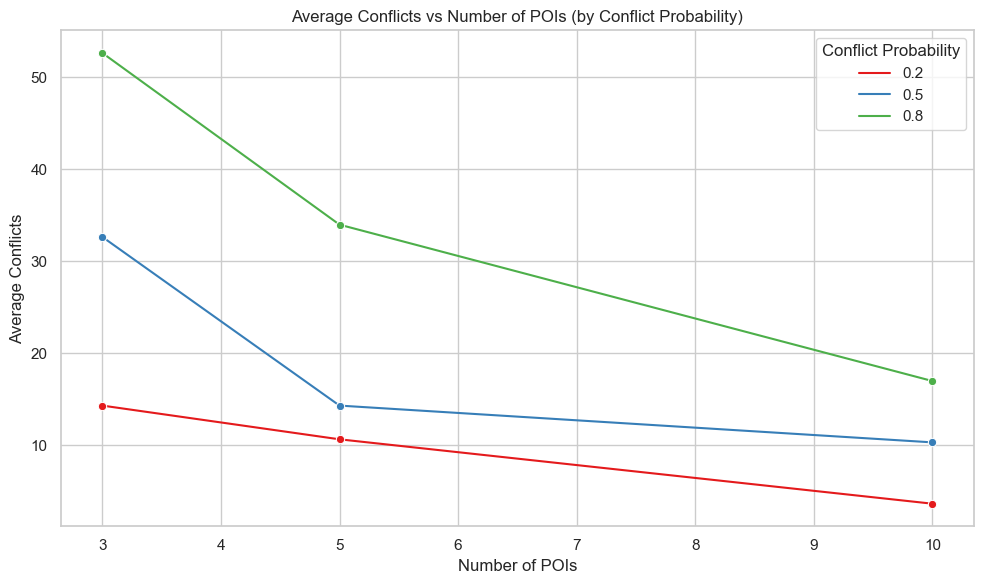

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Lineplot: num_pois vs Avg Conflicts, colored by conflict_prob
sns.lineplot(
    data=grouped,
    x="num_pois",
    y="Avg Conflicts",
    hue="conflict_prob",
    marker="o",
    palette="Set1"
)

# Add plot details
plt.title("Average Conflicts vs Number of POIs (by Conflict Probability)")
plt.xlabel("Number of POIs")
plt.ylabel("Average Conflicts")
plt.legend(title="Conflict Probability")
plt.tight_layout()
plt.show()


## Step 8.2: Visualizing Final Group Sizes by POI Density and Conflict Probability

This plot examines how the final group sizes of **Group A and Group B** change based on two key model parameters:

- **Number of POIs**
- **Conflict Probability**

This visualization helps answer:
- Does one group tend to dominate under certain conditions?
- Are group sizes symmetric (balanced) or asymmetric (dominance)?

We use a **grouped bar chart** to display the average final sizes of Group A and Group B across configurations. To keep the plot readable, we separate each conflict probability level into **subplots**.


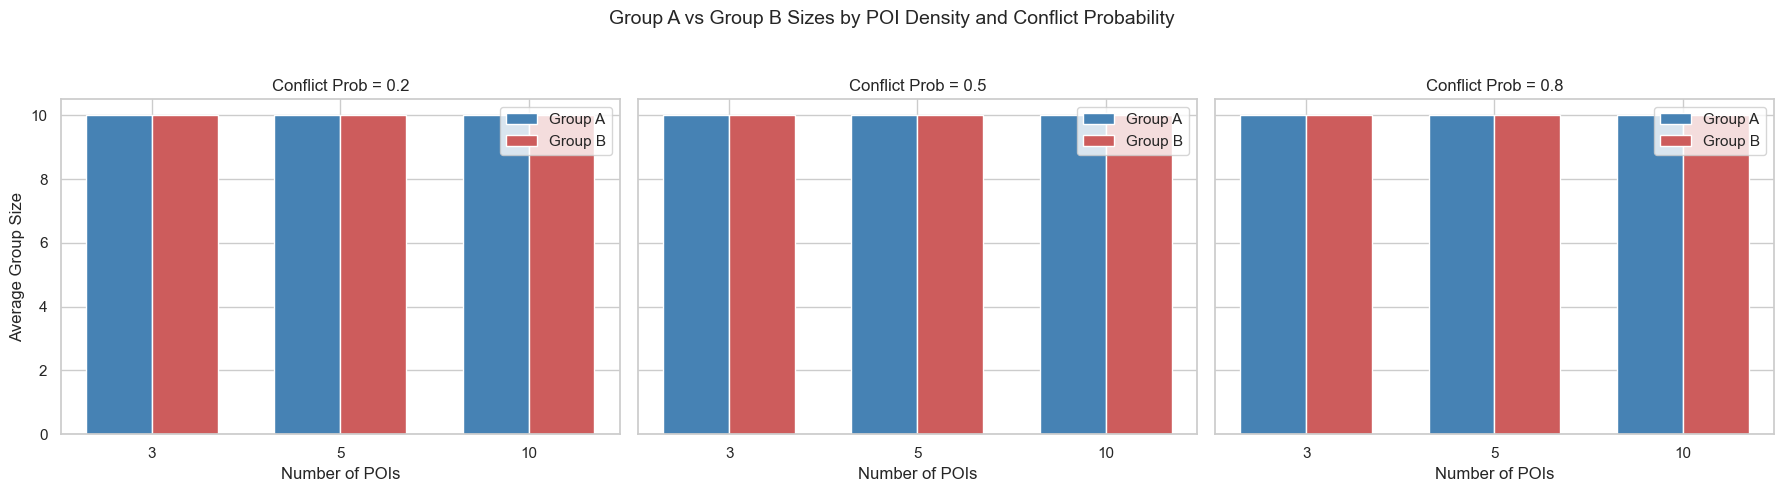

In [61]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define unique conflict probabilities
conflict_levels = grouped["conflict_prob"].unique()

# Set up figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=len(conflict_levels), figsize=(18, 5), sharey=True)

# Set plot style
sns.set(style="whitegrid")

# Loop through each conflict probability to make a subplot
for i, cp in enumerate(conflict_levels):
    subset = grouped[grouped["conflict_prob"] == cp]
    
    # Create bar positions and labels
    bar_width = 0.35
    x = range(len(subset))
    labels = subset["num_pois"]

    # Plot Group A
    axes[i].bar([xi - bar_width/2 for xi in x], subset["Avg Group A"], width=bar_width, label="Group A", color="steelblue")

    # Plot Group B
    axes[i].bar([xi + bar_width/2 for xi in x], subset["Avg Group B"], width=bar_width, label="Group B", color="indianred")

    axes[i].set_title(f"Conflict Prob = {cp}")
    axes[i].set_xticks(x)
    axes[i].set_xticklabels(labels)
    axes[i].set_xlabel("Number of POIs")
    if i == 0:
        axes[i].set_ylabel("Average Group Size")
    axes[i].legend()

plt.suptitle("Group A vs Group B Sizes by POI Density and Conflict Probability", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Step 8.3: Heatmap of Group Dominance Across POI Density and Conflict Probability

In this visualization, we compute the difference between the average final sizes of Group A and Group B for each parameter combination:

> **Dominance Score = Group A Size – Group B Size**

- If **positive**, Group A dominates.
- If **negative**, Group B dominates.
- If **near zero**, both groups coexisted stably.

### Why this visualization?

This heatmap allows us to:
- Quickly detect **any systematic dominance** by one group,
- Identify how **POI density** and **conflict intensity** interact,
- Provide a **visual summary** of group balance in the system.

We use a diverging color palette (blue → white → red) where:
- Red = Group A dominance,
- Blue = Group B dominance,
- White = balance or no dominance.


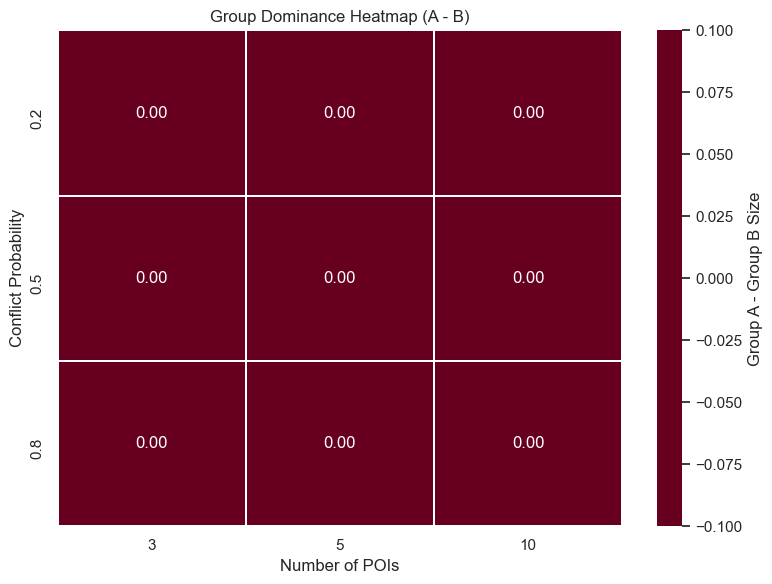

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a copy and compute dominance score
heatmap_data = grouped.copy()
heatmap_data["Dominance"] = heatmap_data["Avg Group A"] - heatmap_data["Avg Group B"]

# Pivot to create matrix for heatmap
dominance_matrix = heatmap_data.pivot(
    index="conflict_prob",
    columns="num_pois",
    values="Dominance"
)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    dominance_matrix,
    annot=True,
    fmt=".2f",
    cmap="RdBu",
    center=0,
    linewidths=0.5,
    cbar_kws={'label': 'Group A - Group B Size'}
)

plt.title("Group Dominance Heatmap (A - B)")
plt.xlabel("Number of POIs")
plt.ylabel("Conflict Probability")
plt.tight_layout()
plt.show()
